# How to write a training loop

This notebook demonstrates how bobbin can support basic training loop of flax models.

## Preamble: Install prerequisites, import modules.

In [1]:
!pip -q install --upgrade pip
!pip -q install --upgrade "jax[cpu]"
!pip -q uninstall -y bobbin
!pip -q install --upgrade git+https://github.com/yotarok/bobbin.git

In [2]:
%%capture
import bobbin
import chex
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

2023-02-20 13:44:51.017469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/google/home/yotaro/cuda/gpus/cuda_11_0/lib64
2023-02-20 13:44:51.017697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/google/home/yotaro/cuda/gpus/cuda_11_0/lib64
2023-02-20 13:44:51.017713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
# Simulate multi-device environment by CPU
chex.set_n_cpu_devices(8)

Array = chex.Array

## Dataset configuration

In this example, we use MNIST dataset from tensorflow_datasets (TFDS) for explanation.
Random batches can be obtained from the MNIST training dataset by the following function.

In [4]:
def get_dataset(batch_size):
    ds = tfds.load("mnist", split="train", as_supervised=True)
    ds = ds.repeat().shuffle(1024).batch(batch_size).prefetch(1)
    return ds

## Model definition

The model we used for demonstration is a simple feed-forward networks with 2 hidden layer with a sigmoid activation function.  Dropout is also applied for demonstrating how random number generators (RNGs) can be handled.

In [5]:
class MnistClassifier(nn.Module):
    @nn.compact
    def __call__(self, x: Array, *, training=True) -> Array:
        batch_size, *unused_image_dims = x.shape
        x = x.reshape((batch_size, -1))  # flatten the input image.
        hidden = nn.sigmoid(nn.Dense(features=1024)(x))
        hidden = nn.Dropout(0.5)(hidden, deterministic=not training)
        return nn.Dense(features=10)(hidden)

## `TrainTask` definition

For bobbin-based training loop, a subclass of `bobbin.TrainTask` should be defined for defining all training related artifacts.
In the below example, we specified the following details of description:

* How to compute loss function in overridden `compute_loss` function,
* A model to be trained passed to the base-class constructor.
* A fake input batch used for initializing the parameters passed to the base-class constructor as `example_args` argument.
* A list of extra RNG names required for model initialization passed to the base-class constructor as `required_rngs` argument.

It should be noted that the `required_rngs` argument does not have to include "params", as it is always used for initialization.

In [6]:
class MnistTrainingTask(bobbin.TrainTask):
    def __init__(self):
        super().__init__(
            MnistClassifier(),
            example_args=(
                np.zeros((1, 28, 28, 1), np.float32),  # comma-here is important
            ),
            required_rngs=("dropout",),
        )

    def compute_loss(self, params, batch, *, extra_vars, prng_key, step):
        images, labels = batch
        logits = self.model.apply(
            {"params": params}, images, rngs=self.get_rng_dict(prng_key)
        )
        per_sample_loss = optax.softmax_cross_entropy(
            logits=logits, labels=jax.nn.one_hot(labels, 10)
        )
        return jnp.mean(per_sample_loss), ({}, None)

Here, the return value of `compute_loss` is a bit complicated for this task.
`compute_loss` is expected to return
`(loss, (updated_vars, loss_aux_info): Tuple[float, Tuple[VariableCollection, LossAuxInfo]]`.
In addition to the loss value as in `loss`, this function can update some non-trainable variable by returning `updated_vars` and some auxiliary info via `loss_aux_info`.
Here, we set `updated_vars` to be an empty dictionary, and `loss_aux_info` to be None.

## Initialization of `TrainState` and step function

Once we have a definition for task, we can initialize the `train_state`, which contains everything needed for continuing training can be initialized as follows:

In [7]:
task = MnistTrainingTask()
train_state = task.initialize_train_state(jax.random.PRNGKey(0), optax.sgd(0.01))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Here, the first argument for `initialize_train_state` is a base RNG seed used for initialization, and the second argument for `initialize_train_state` is an instance of `optax.GradientTransformation`, i.e. optimizer used in the training.

In addition to training state, we prepare the function that maps training state to the updated training state.  This can be done by calling `TrainingTask.make_training_step_fn`, as follows:

In [8]:
train_step_fn = task.make_training_step_fn().pmap("d")

The return value of `make_training_step_fn` is a "configurable" function that can transform itself with some methods. Here, we call `train_step_fn.pmap("d")` for parallelizing the computation across multiple devices ("d" is passed as a `axis_name` parameter of `jax.pmap`).
pmapped version of `train_step_fn` maps replicated version of `TrainState` so we also need to convert `TrainState` so it is compatible with the step function, as follows:

In [9]:
print(f"{train_state.step=}")
train_state = flax.jax_utils.replicate(train_state, jax.local_devices())
print(f"replicated version of {train_state.step=}")

train_state.step=0
replicated version of train_state.step=Array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32, weak_type=True)


As we see in the previous outputs, replication copies the same values across the devices, and from the Python interpreter, it can be seen as an array with an extra leading axis for each device.

## Run the training loop

Once we got everything, `train_state` and `train_step_fn`, ready, training can be written simply by repeating `(train_state, ...) =  train_step_fn(train_state, batch, ...)`. Here, we do this over the first 500 batches from the dataset.

In [10]:
prng_key = jax.random.PRNGKey(0)
step_infos = []
for batch in get_dataset(64).take(500).as_numpy_iterator():
    rng, prng_key = jax.random.split(prng_key)
    train_state, step_info = train_step_fn(train_state, batch, rng)
    step_infos.append(step_info)

2023-02-20 13:44:53.749790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/google/home/yotaro/cuda/gpus/cuda_11_0/lib64
2023-02-20 13:44:53.755208: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-20 13:45:06.729735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen 

It should be noted that we had an extra complication due to RNGs.  For each step, we need new RNG seed for Dropout module used in the model.  This is done by splitting the root RNG (here defined as `jax.random.PRNGKey(0)`) for each usage of RNG.

The return value of `train_step_fn` is actually a pair of updated `train_state` and `step_info: bobbin.training.StepInfo` that carries auxiliary information obtained during the step.
`StepInfo` has the following fields:

* StepInfo.loss: loss value.
* StepInfo.loss_aux_out: auxiliary output from the loss function. In this example, our `compute_loss` returns None, so this field must be None.

For pmapped version of `train_step_fn`, `StepInfo` is also replicated as follows:

In [11]:
print(step_infos[0])

StepInfo(loss=Array([2.9141948, 2.6939518, 3.0465186, 2.6297505, 2.486627 , 2.4461143,
       2.5025089, 2.1186543], dtype=float32), loss_aux_out=None)


So here, `np.mean` is applied to obtain actual loss values used for optimization, that are means over devices.

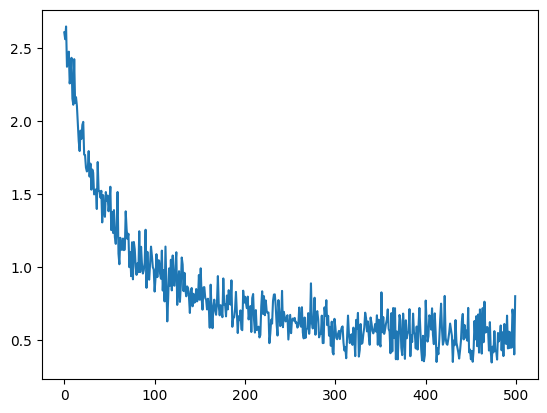

In [12]:
losses = [np.mean(step_info.loss) for step_info in step_infos]
plt.plot(losses)